# Car Parking checker


Enric Ferrera González  
Miguel López Manzanares  
Joan Marc  

El objectiu del projecte de visió per computador es crear un programa que comprovi les plaçes d'aparcament d'un parking. Si están buides o plenes y en cas de que estiguin plenes, detectar la matrícula del coche, el color y si es pot la marca.  

Es realitzará de dues maneres, primer amb métodes clásics de la visió per computador y després amb métodes moderns com, per exemple, les xarxes neuronals. 

# Part clàsica

### 1. Dectectar línies
Per començar la part clàsica volem detectar les línies de les plaçes d'aparcament.

Per detectar les línies d'aparcament en una imatge d'un aparcament utilitzant mètodes clàssics de visió per computador, es poden seguir els següents passos:

1. **Conversió a escala de grisos:** Facilita el processament de la imatge.
2. **Filtrat de soroll:** S'utilitza un filtre com el Gaussian Blur per reduir el soroll.
3. **Detecció de vores:** S'aplica l'algoritme de Canny per detectar les vores de la imatge.
4. **Transformada de Hough:** Permet detectar línies rectes a la imatge, que corresponen a les línies d'aparcament.
5. **Dibuix de les línies detectades:** Es mostren les línies sobre la imatge original per visualitzar el resultat.

Aquests passos es poden implementar amb la llibreria OpenCV.

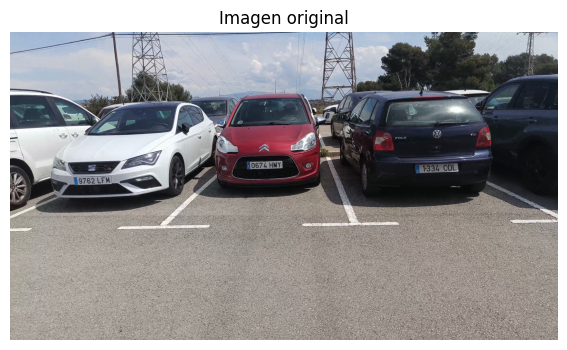

In [439]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_image(img, title="", cmap='gray'):
    plt.figure(figsize=(12, 4))
    if len(img.shape) == 2:  # grayscale
        plt.imshow(img, cmap=cmap)
    else:  # BGR to RGB for color images
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Cargar imagen
image = cv2.imread("frames/frame_0003.jpg")
original = image.copy()
show_image(image, "Imagen original")

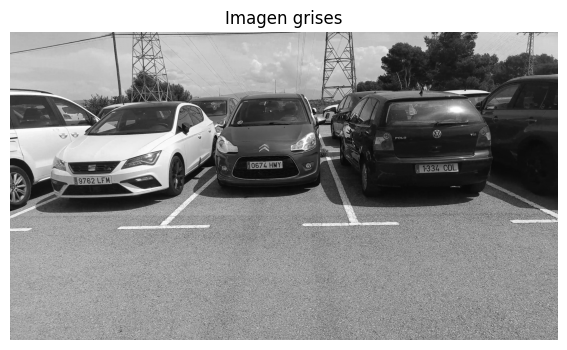

In [440]:
# Convertir a escala de grises
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
show_image(gray, "Imagen grises")

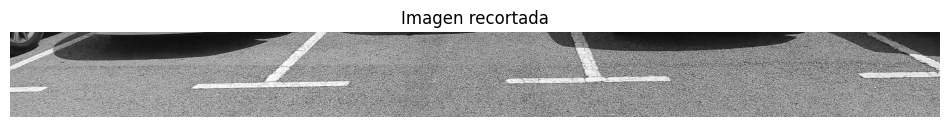

In [441]:
# Recortar si es necesario (ajustar offset si ya recortabas antes)
roi = gray[1150:1500, :]
roi_color = image[1150:1500, :]
show_image(roi, "Imagen recortada")

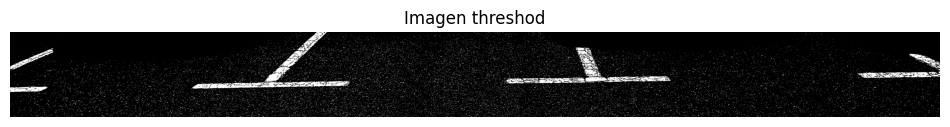

In [442]:
# Aplicar un threshold simple
_, thresh = cv2.threshold(roi, 220, 255, cv2.THRESH_BINARY)
show_image(thresh, "Imagen threshod")

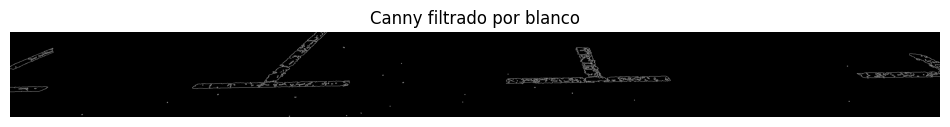

In [443]:
# --- Paso 3: Suavizado y Canny ---
blur = cv2.GaussianBlur(thresh, (3, 3), 0)
edges = cv2.Canny(blur, 500, 1000)
show_image(edges, "Canny filtrado por blanco")

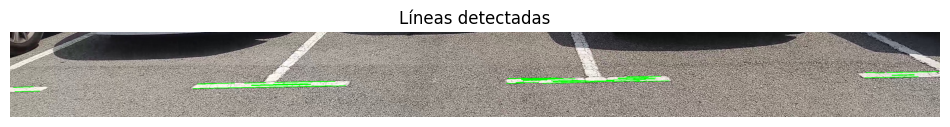

In [444]:
# --- Paso 4: Detección de líneas con Hough ---
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=70, maxLineGap=20)
line_img = roi_color.copy()

'''
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
'''
        
# Dibuixar només les línies amb angle gairebé horitzontal o vertical
line_img = roi_color.copy()
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.degrees(np.arctan2((y2 - y1), (x2 - x1)))
        if abs(angle) < 5 or abs(angle - 90) < 5 or abs(angle + 90) < 5:
            cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

show_image(line_img, "Líneas detectadas")


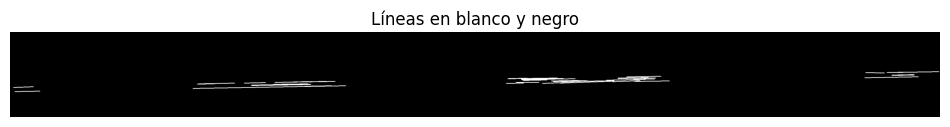

In [445]:
# Las ponemos en una imagen negra para poder contar bordes
# Crear imagen negra con las mismas dimensiones
line_mask = np.zeros_like(edges)

# Dibujar las líneas en blanco (valor 255)
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.degrees(np.arctan2((y2 - y1), (x2 - x1)))
        if abs(angle) < 5 or abs(angle - 90) < 5 or abs(angle + 90) < 5:
            cv2.line(line_mask, (x1, y1), (x2, y2), 255, 2)

show_image(line_mask, "Líneas en blanco y negro")

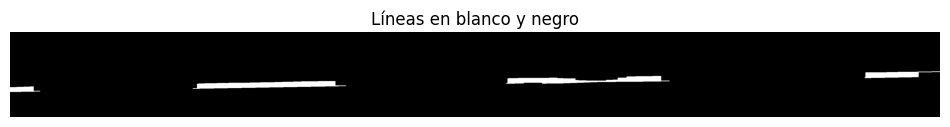

Regiones horizontales detectadas: 4
Plazas de parking detectadas: 3


In [446]:
# Asegurarse de que es binaria
_, binaria = cv2.threshold(line_mask, 127, 255, cv2.THRESH_BINARY)

# Opcional: cerrar huecos pequeños dentro de las regiones
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (55, 45))  # más ancho que alto
cerrada = cv2.morphologyEx(binaria, cv2.MORPH_CLOSE, kernel)
show_image(cerrada, "Líneas en blanco y negro")

# Encontrar contornos (cada uno será una región horizontal)
contornos, _ = cv2.findContours(cerrada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filtrar contornos por forma: horizontales (ancho >> alto)
regiones_horizontales = []
for c in contornos:
    x, y, w, h = cv2.boundingRect(c)
    if w > 2*h:  # puedes ajustar esta condición
        regiones_horizontales.append((x, y, w, h))

print(f"Regiones horizontales detectadas: {len(regiones_horizontales)}")
print(f"Plazas de parking detectadas: {len(regiones_horizontales)-1}")


### Part2  
Ara detectarem les regions entre les línies per veure si hi ha un coche aparcat

In [447]:
regiones_ordenadas = sorted(regiones_horizontales, key=lambda r: r[0])


espacios_entre_regiones = []

for i in range(len(regiones_ordenadas) - 1):
    x1, _, w1, _ = regiones_ordenadas[i]
    x2, _, _, _ = regiones_ordenadas[i + 1]
    
    extremo_derecho = x1 + w1
    inicio_siguiente = x2

    if inicio_siguiente > extremo_derecho:
        espacio = (extremo_derecho, inicio_siguiente)  # coordenadas X del espacio entre regiones
        espacios_entre_regiones.append(espacio)


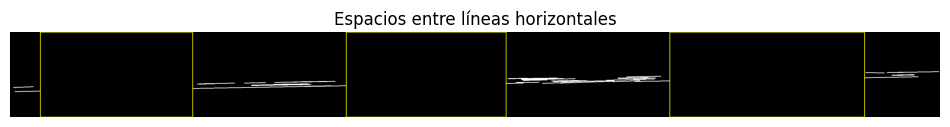

In [448]:
imagen_resultado = cv2.cvtColor(binaria, cv2.COLOR_GRAY2BGR)
alto_img = imagen_resultado.shape[0]

for x1, x2 in espacios_entre_regiones:
    cv2.rectangle(imagen_resultado, (x1, 0), (x2, alto_img), (0, 255, 255), 2)

show_image(imagen_resultado, "Espacios entre líneas horizontales")


Ahora con estás coordenadas, detectaremos si hay un coche en la parte de arriba de esa región

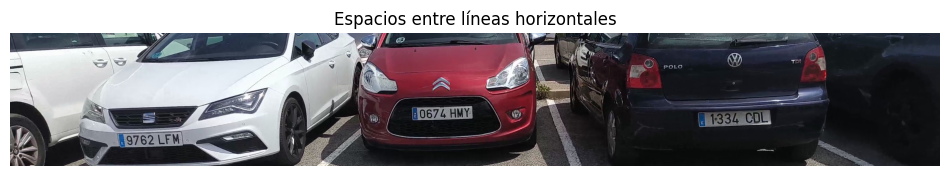

In [454]:
recorte = original[600:1150, :]
show_image(recorte, "Espacios entre líneas horizontales")


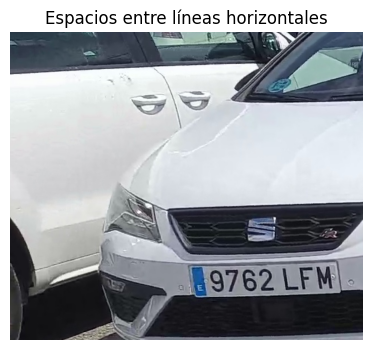

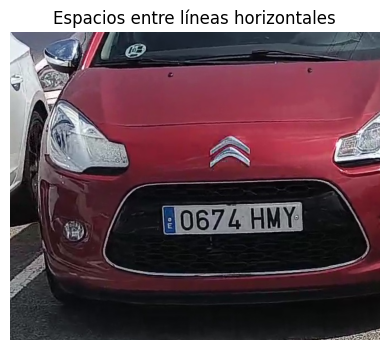

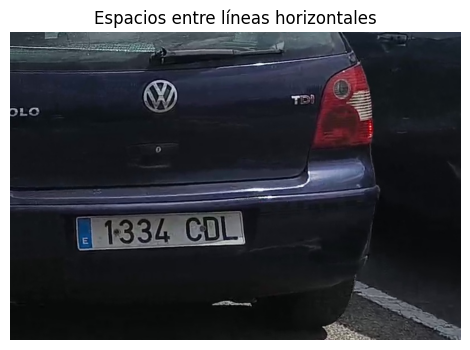

In [455]:
for i, (x_inicio, x_fin) in enumerate(espacios_entre_regiones, start=1):
    recorte_coche = recorte[:, x_inicio:x_fin]
    filename = f'coches/coche_{i}.jpg'
    cv2.imwrite(filename, recorte_coche)
    show_image(recorte_coche, "Espacios entre líneas horizontales")

# Part4
### Detección de la marca
Se plantea buscar el sitio dónde está la matrícula

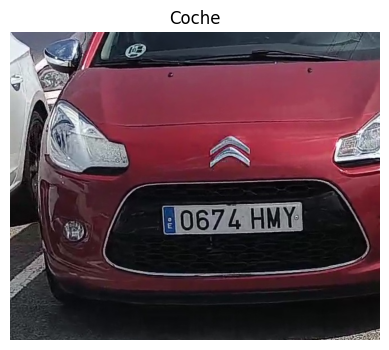

In [517]:
img_car = cv2.imread("coches/coche_2.jpg")
show_image(img_car, "Coche")

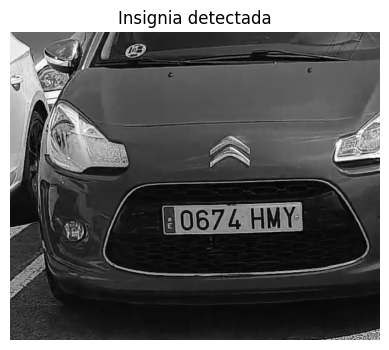

In [518]:
# Convertir a escala de grises
gray_car = cv2.cvtColor(img_car, cv2.COLOR_BGR2GRAY)
show_image(gray_car, "Insignia detectada")

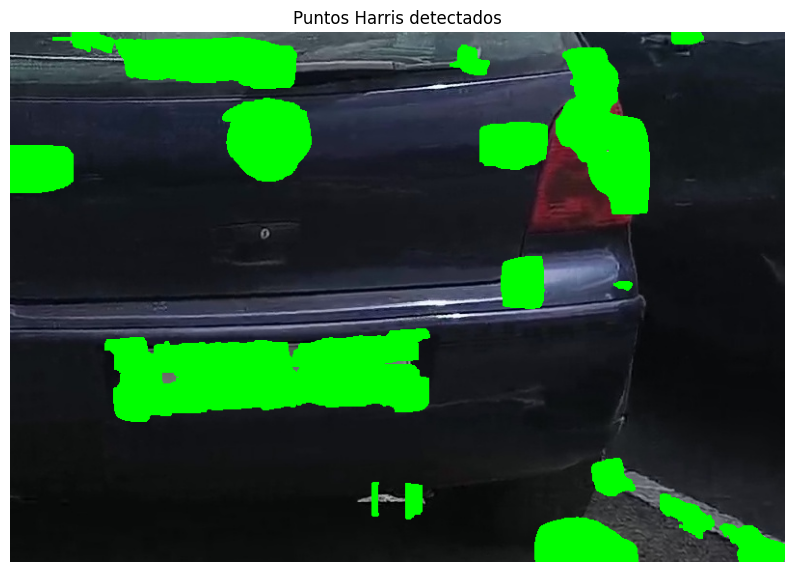

In [546]:
img_car = cv2.imread("coches/coche_3.jpg")

# Convertir a escala de grises
gray_car = cv2.cvtColor(img_car, cv2.COLOR_BGR2GRAY)

# Convertir a float32 porque Harris lo requiere
gray32_car = np.float32(gray_car)

# Detectar esquinas con Harris
dst = cv2.cornerHarris(gray32_car, blockSize=40, ksize=3, k=0.06)

# Dilatar para marcar mejor las esquinas
dst = cv2.dilate(dst, None)

# Umbral para seleccionar las esquinas fuertes
img_car[dst > 0.01 * dst.max()] = [0, 255, 0]  # marcar en verde

# Mostrar resultado
plt.figure(figsize=(10,8))
plt.imshow(cv2.cvtColor(img_car, cv2.COLOR_BGR2RGB))
plt.title('Puntos Harris detectados')
plt.axis('off')
plt.show()

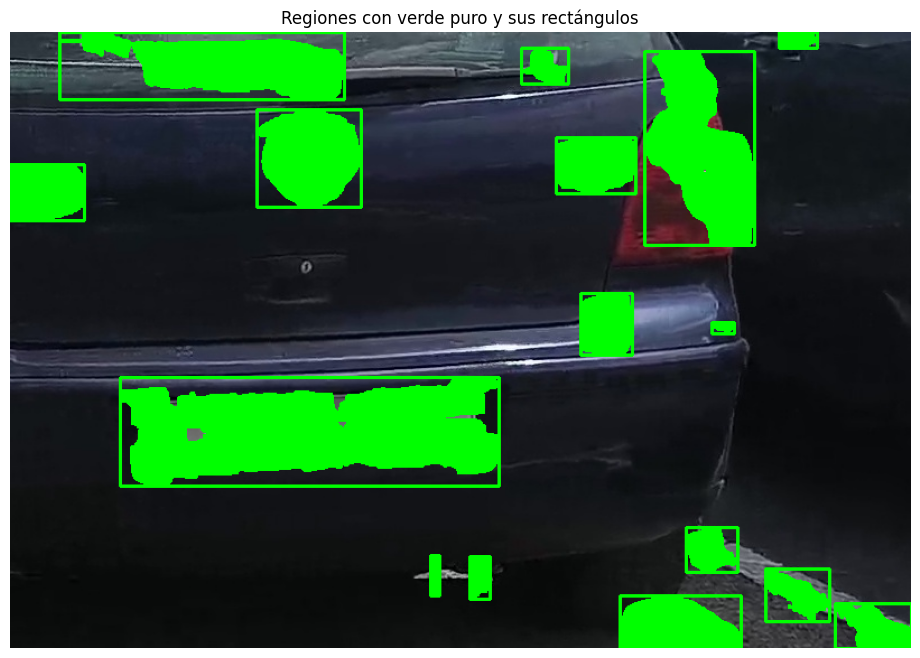

In [547]:
# Crear máscara con solo píxeles que sean exactamente verde puro
# Recuerda que OpenCV lee en BGR, así que verde puro es [0, 255, 0]
mask = cv2.inRange(img_car, np.array([0, 255, 0]), np.array([0, 255, 0]))

# Encontrar contornos de la máscara
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dibujar rectángulos alrededor de las regiones verdes
img_rects = img_car.copy()
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(img_rects, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.figure(figsize=(12, 8))
plt.title("Regiones con verde puro y sus rectángulos")
plt.imshow(cv2.cvtColor(img_rects, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Se encontraron 16 contornos.

Contorno #1:
  Área: 1624.50 píxeles
  Rectángulo: x=736, y=510, ancho=68, alto=40


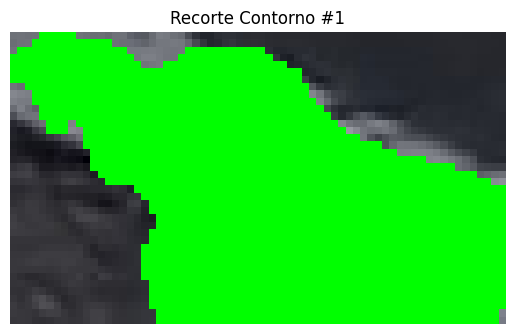

Contorno #2:
  Área: 3892.50 píxeles
  Rectángulo: x=544, y=503, ancho=108, alto=47


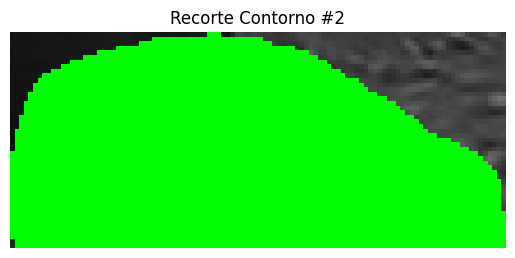

Contorno #3:
  Área: 1272.00 píxeles
  Rectángulo: x=674, y=479, ancho=57, alto=47


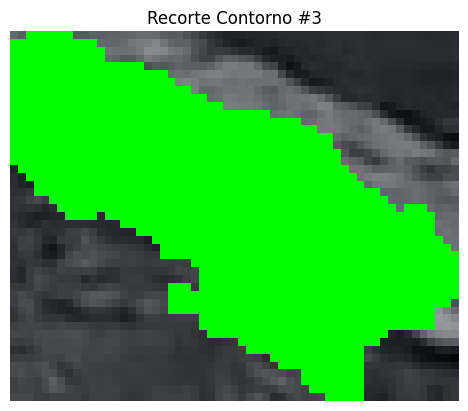

Contorno #4:
  Área: 562.50 píxeles
  Rectángulo: x=410, y=468, ancho=18, alto=38


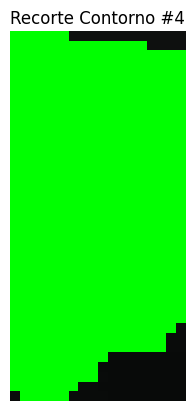

Contorno #5:
  Área: 214.50 píxeles
  Rectángulo: x=375, y=467, ancho=8, alto=36


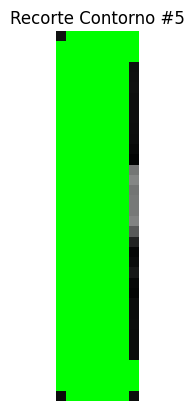

Contorno #6:
  Área: 1203.50 píxeles
  Rectángulo: x=603, y=442, ancho=46, alto=40


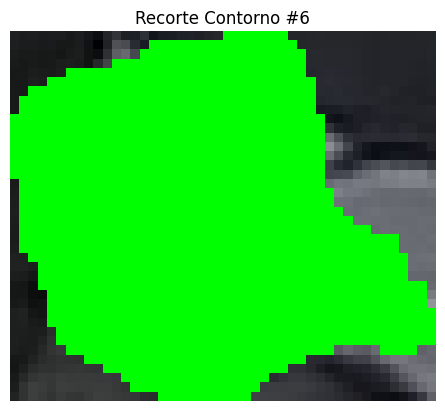

Contorno #7:
  Área: 23045.50 píxeles
  Rectángulo: x=98, y=308, ancho=338, alto=97


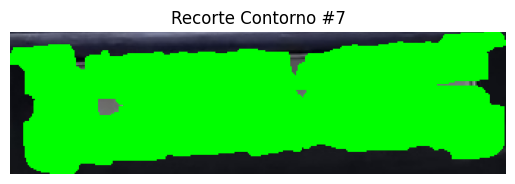

Contorno #8:
  Área: 119.50 píxeles
  Rectángulo: x=626, y=259, ancho=20, alto=10


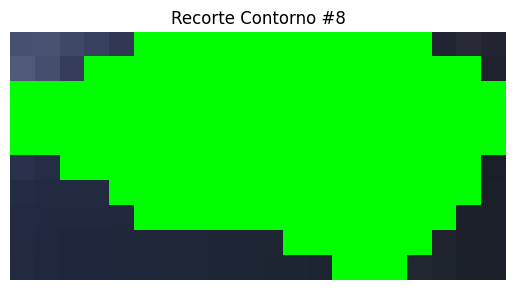

Contorno #9:
  Área: 2191.50 píxeles
  Rectángulo: x=509, y=233, ancho=46, alto=55


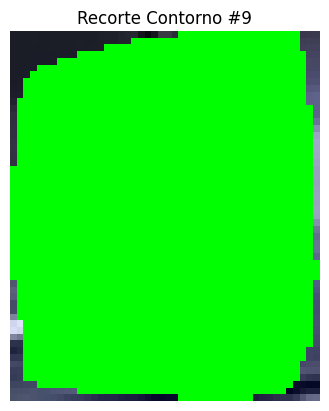

Contorno #10:
  Área: 2992.50 píxeles
  Rectángulo: x=0, y=118, ancho=66, alto=50


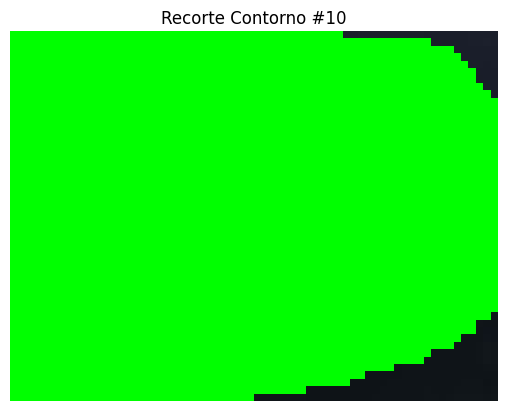

Contorno #11:
  Área: 3026.50 píxeles
  Rectángulo: x=487, y=94, ancho=71, alto=50


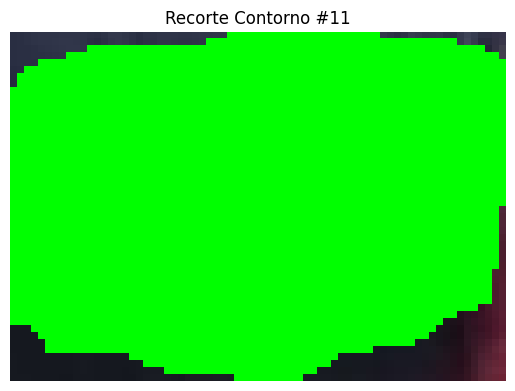

Contorno #12:
  Área: 5993.00 píxeles
  Rectángulo: x=220, y=69, ancho=93, alto=87


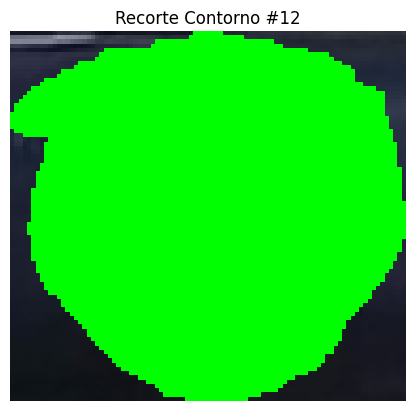

Contorno #13:
  Área: 10049.50 píxeles
  Rectángulo: x=566, y=17, ancho=98, alto=173


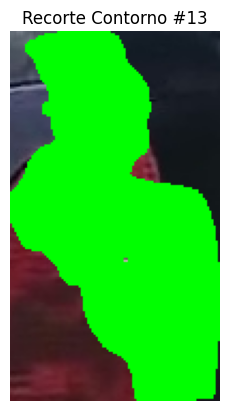

Contorno #14:
  Área: 728.00 píxeles
  Rectángulo: x=456, y=14, ancho=42, alto=32


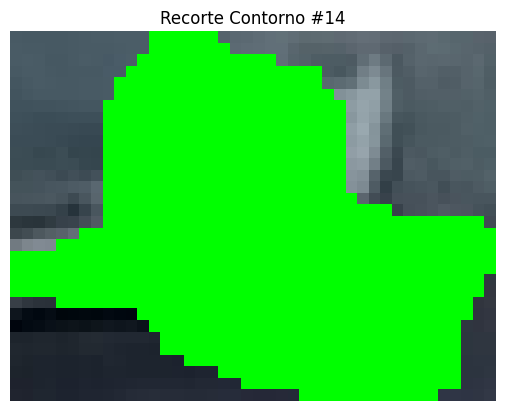

Contorno #15:
  Área: 390.00 píxeles
  Rectángulo: x=686, y=0, ancho=34, alto=14


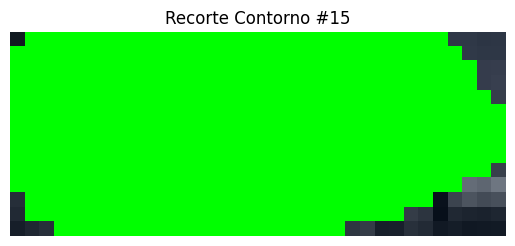

Contorno #16:
  Área: 8672.00 píxeles
  Rectángulo: x=44, y=0, ancho=254, alto=60


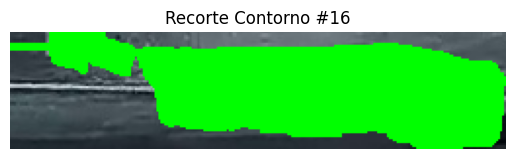

In [548]:
print(f"Se encontraron {len(contours)} contornos.\n")

for i, cnt in enumerate(contours):
    area = cv2.contourArea(cnt)
    x, y, w, h = cv2.boundingRect(cnt)
    
    print(f"Contorno #{i+1}:")
    print(f"  Área: {area:.2f} píxeles")
    print(f"  Rectángulo: x={x}, y={y}, ancho={w}, alto={h}")
    
    # Recortar la región en la imagen original
    recorte = img_car[y:y+h, x:x+w]
    
    # Mostrar recorte
    plt.figure()
    plt.title(f"Recorte Contorno #{i+1}")
    plt.imshow(cv2.cvtColor(recorte, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

Se encontraron 16 contornos.

Contorno filtrado #1:
  Área: 5993.00 píxeles
  Rectángulo: x=220, y=69, ancho=93, alto=87


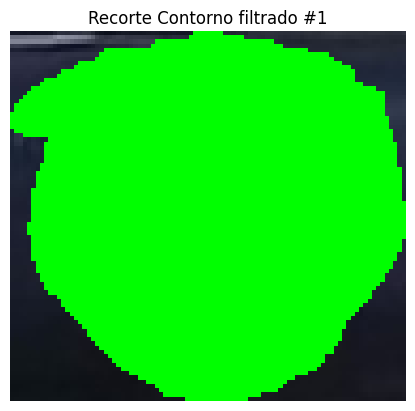

In [552]:
# Tamaños deseados (ancho, alto)
target_sizes = [(117, 86), (96, 78), (93, 87)]
tolerance = 10  # píxeles

def size_match(w, h, targets, tol):
    for tw, th in targets:
        if abs(w - tw) <= tol and abs(h - th) <= tol:
            return True
    return False

print(f"Se encontraron {len(contours)} contornos.\n")

count_filtered = 0

for i, cnt in enumerate(contours):
    area = cv2.contourArea(cnt)
    x, y, w, h = cv2.boundingRect(cnt)
    
    if size_match(w, h, target_sizes, tolerance):
        count_filtered += 1
        print(f"Contorno filtrado #{count_filtered}:")
        print(f"  Área: {area:.2f} píxeles")
        print(f"  Rectángulo: x={x}, y={y}, ancho={w}, alto={h}")
        
        recorte = img_car[y:y+h, x:x+w]
        plt.figure()
        plt.title(f"Recorte Contorno filtrado #{count_filtered}")
        plt.imshow(cv2.cvtColor(recorte, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

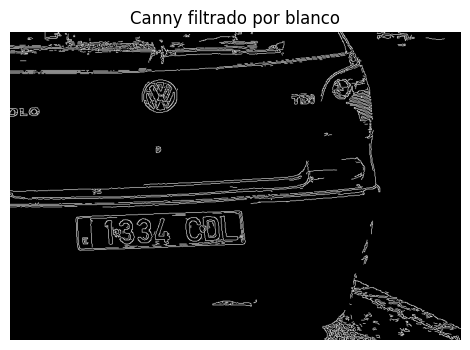

In [549]:
edges = cv2.Canny(gray_car, 100, 200)
show_image(edges, "Canny filtrado por blanco")

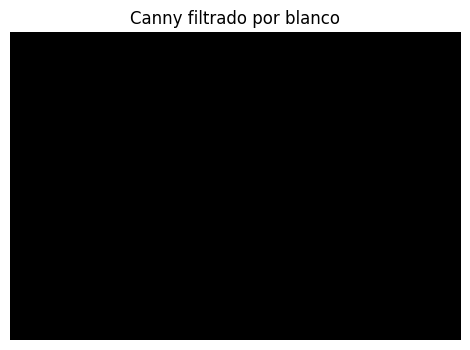

In [550]:
blur = cv2.GaussianBlur(gray_car, (3, 3), 0)
edges = cv2.Canny(blur, 500, 1000)
show_image(edges, "Canny filtrado por blanco")

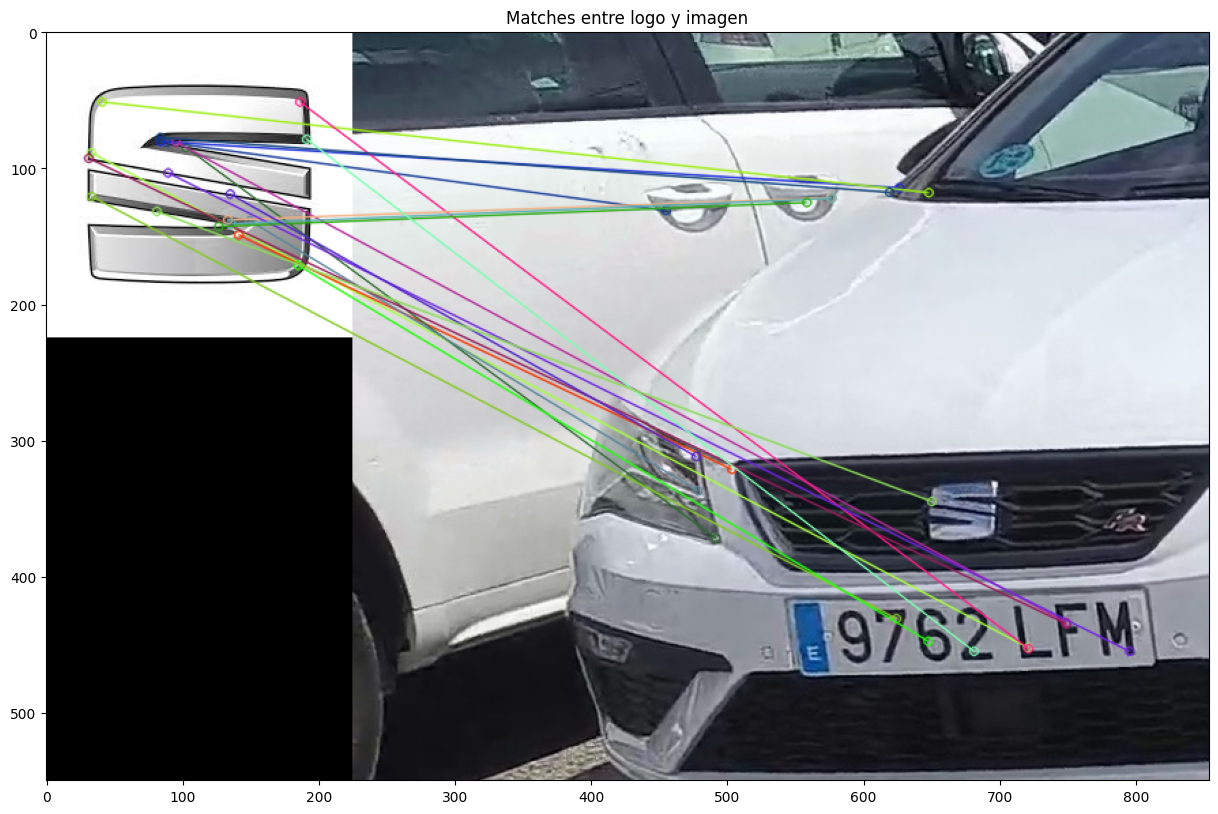

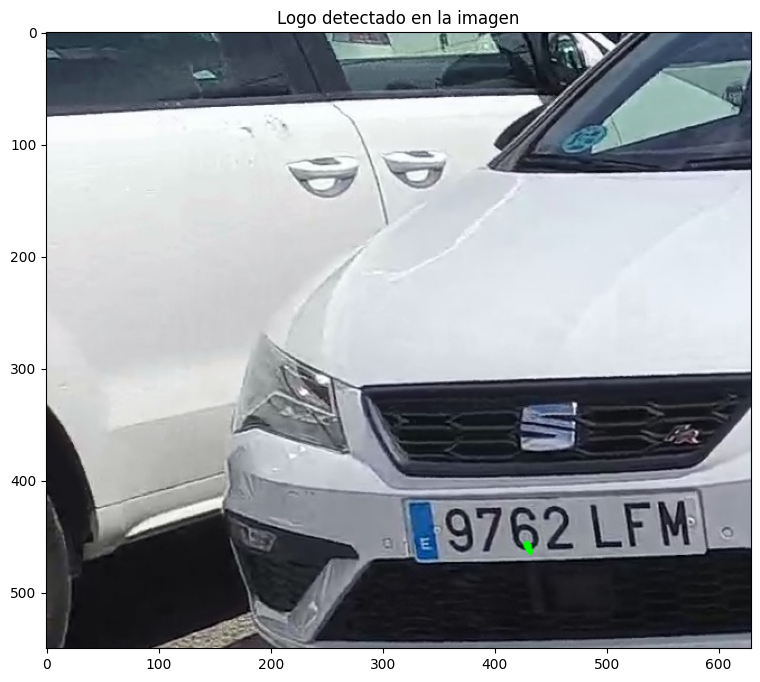

In [551]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Carga la imagen principal y la plantilla del logo
img = cv2.imread('coches/coche_1.jpg')
template_logo = cv2.imread('logos/seat.jpg')

# Convierte a escala de grises
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_logo = cv2.cvtColor(template_logo, cv2.COLOR_BGR2GRAY)

# Crear detector ORB
orb = cv2.ORB_create()

# Detectar keypoints y descriptores
kp1, des1 = orb.detectAndCompute(gray_logo, None)
kp2, des2 = orb.detectAndCompute(gray_img, None)

# Crear matcher Brute Force con distancia Hamming
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Hacer matching entre descriptores
matches = bf.match(des1, des2)

# Ordenar matches por distancia (menor distancia = mejor match)
matches = sorted(matches, key=lambda x: x.distance)

# Mostrar los mejores matches (por ejemplo, los 20 mejores)
img_matches = cv2.drawMatches(template_logo, kp1, img, kp2, matches[:20], None, flags=2)

plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title("Matches entre logo y imagen")
plt.show()

# Opcional: Usar RANSAC para encontrar homografía y localizar logo en la imagen

if len(matches) > 10:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    h,w = gray_logo.shape
    pts = np.float32([[0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)

    img_detected = img.copy()
    cv2.polylines(img_detected, [np.int32(dst)], True, (0,255,0), 3, cv2.LINE_AA)

    plt.figure(figsize=(10,8))
    plt.imshow(cv2.cvtColor(img_detected, cv2.COLOR_BGR2RGB))
    plt.title("Logo detectado en la imagen")
    plt.show()
else:
    print("No se encontraron suficientes matches para localizar el logo.")
